In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.regularizers import l2

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553476096/553467096 [==============================] - 21s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
   
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
   
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]

    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
      
            caption = caption.lower()
       
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
mapping['1048710776_bb5b0a5c7c']

['a couple of several people sitting on a ledge overlooking the beach',
 'A group of people sit on a wall at the beach .',
 'A group of teens sit on a wall by a beach .',
 'Crowd of people at the beach .',
 'Several young people sitting on a rail above a crowded beach .']

In [12]:
clean(mapping)

In [13]:
mapping['1048710776_bb5b0a5c7c']

['startseq couple of several people sitting on ledge overlooking the beach endseq',
 'startseq group of people sit on wall at the beach endseq',
 'startseq group of teens sit on wall by beach endseq',
 'startseq crowd of people at the beach endseq',
 'startseq several young people sitting on rail above crowded beach endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[11:20]

['startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq',
 'startseq man lays on bench while his dog sits by him endseq',
 'startseq man lays on the bench to which white dog is also tied endseq',
 'startseq man sleeping on bench outside with white and black dog sitting next to him endseq',
 'startseq shirtless man lies on park bench with his dog endseq',
 'startseq man laying on bench holding leash of dog sitting on ground endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
val = image_ids[split:]

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [26]:
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, add, BatchNormalization, SimpleRNN
from tensorflow.keras.optimizers import Adam
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(fe1)
fe2 = BatchNormalization()(fe2)

# Sequence Feature Layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = SimpleRNN(512, return_sequences=False)(se2)

# Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
decoder2 = Dropout(0.2)(decoder2)
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=5e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 35)]         0                                            
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 4096)         0           input_5[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 256)      2172160     text[0][0]                       
____________________________________________________________________________________________

In [27]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    # create data generator for training
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    history = model.fit(
        train_generator, 
        epochs=1, 
        steps_per_epoch=steps, 
        validation_data=val_generator, 
        validation_steps=len(val) // batch_size,  
        verbose=1
    )
    
    print(f"Epoch {i+1}/{epochs}")
    print(f"Train Loss: {history.history['loss'][0]:.4f} - Train Accuracy: {history.history['accuracy'][0]:.4f}")
    print(f"Validation Loss: {history.history['val_loss'][0]:.4f} - Validation Accuracy: {history.history['val_accuracy'][0]:.4f}")


227/227 [==============================] - 43s 186ms/step - loss: 5.5449 - accuracy: 0.1388 - val_loss: 4.8314 - val_accuracy: 0.1906
Epoch 1/20
Train Loss: 5.5449 - Train Accuracy: 0.1388
Validation Loss: 4.8314 - Validation Accuracy: 0.1906
227/227 [==============================] - 43s 191ms/step - loss: 4.3790 - accuracy: 0.2298 - val_loss: 4.1745 - val_accuracy: 0.2522
Epoch 2/20
Train Loss: 4.3790 - Train Accuracy: 0.2298
Validation Loss: 4.1745 - Validation Accuracy: 0.2522
227/227 [==============================] - 44s 193ms/step - loss: 3.9021 - accuracy: 0.2700 - val_loss: 3.9711 - val_accuracy: 0.2757
Epoch 3/20
Train Loss: 3.9021 - Train Accuracy: 0.2700
Validation Loss: 3.9711 - Validation Accuracy: 0.2757
227/227 [==============================] - 43s 190ms/step - loss: 3.6320 - accuracy: 0.2925 - val_loss: 3.8688 - val_accuracy: 0.2877
Epoch 4/20
Train Loss: 3.6320 - Train Accuracy: 0.2925
Validation Loss: 3.8688 - Validation Accuracy: 0.2877
227/227 [===================

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [31]:
!git clone https://github.com/salaniz/pycocoevalcap.git
%cd pycocoevalcap
!pip install -r requirements.txt
!python setup.py install
%cd ..

Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 821 (delta 5), reused 15 (delta 4), pack-reused 797 (from 1)
Receiving objects: 100% (821/821), 130.06 MiB | 19.58 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/kaggle/working/pycocoevalcap
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
running install
/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/opt/conda/lib/python3.7/site-packages/setuptools/command/easy_install.py:159: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  EasyInstallDeprecationWarning,
running bdist_egg
running egg_info
creating pycoc

In [33]:
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.cider.cider import Cider

actual, predicted = list(), list()

for key in tqdm(val):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.556944
BLEU-2: 0.332434


AttributeError: 'list' object has no attribute 'keys'

In [34]:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.556944
BLEU-2: 0.332434


In [41]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):

    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq group of backpackers lay on the dry ground endseq
startseq group of hikers are resting on the ground in front of some mountains endseq
startseq people camp with the mountains in the background endseq
startseq several hikers rest with their gear in front of mountain endseq
startseq the group of hikers is resting in front of mountain endseq
--------------------Predicted--------------------
startseq group of backpackers jump on rocky hill endseq


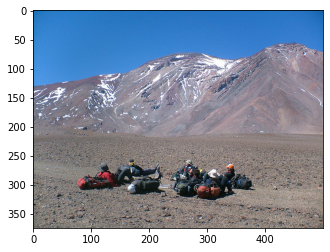

In [42]:
generate_caption("1093716555_801aacef79.jpg")

---------------------Actual---------------------
startseq boy lays on picnic table bench endseq
startseq child is laying down on wooden bench endseq
startseq child is on bench with arms stretched out endseq
startseq little boy in red shirt sitting on wooden picnic table bench endseq
startseq little boy lies down on picnic table bench endseq
--------------------Predicted--------------------
startseq little girl in red shirt lays on picnic table bench endseq


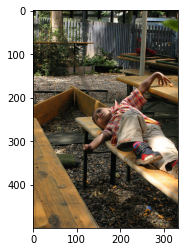

In [43]:
generate_caption("1204996216_71d7519d9a.jpg")

---------------------Actual---------------------
startseq dog in number six jersey is running through field endseq
startseq dog is leaping through the grass endseq
startseq dog is wearing red number and running through field of green grass while being chased by bird endseq
startseq white and tan dog leaps through the air endseq
startseq the dog in vest leaps in the air and there is bird flying endseq
--------------------Predicted--------------------
startseq dog with muzzle and red and black dog running through field endseq


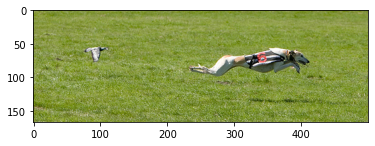

In [44]:
generate_caption("1240297429_c36ae0c58f.jpg")

---------------------Actual---------------------
startseq lady holds little girl who is trying to catch bubbles endseq
startseq woman is holding little girl who is trying to catch bubbles endseq
startseq woman with holding young girl playing with bubbles at picnic endseq
startseq "a young woman in blue shirt stands holding young girl in denim dress ." endseq
startseq there is woman holding her baby daughter while the daughter claps endseq
--------------------Predicted--------------------
startseq girl in pink dress and turquoise dress is standing in front of fountain endseq


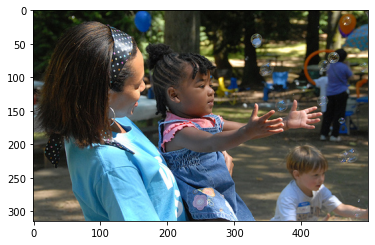

In [45]:
generate_caption("1237985362_dbafc59280.jpg")

---------------------Actual---------------------
startseq smiling girls in bathing suits sitting on the sand endseq
startseq group of friends smile for picture at the beach endseq
startseq group of young ladies in bikinis endseq
startseq the three girls in bathing suits are all smiles endseq
startseq the three girls sat on the beach endseq
--------------------Predicted--------------------
startseq two girls in bikinis are posing for picture endseq


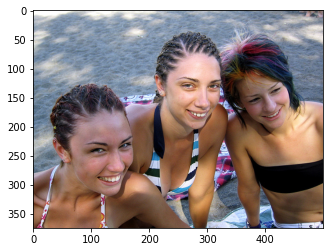

In [46]:
generate_caption("1244306891_8e78ae1620.jpg")

In [60]:
video_path = '/kaggle/input/cat-video/WhatsApp Video 2024-12-01 at 4.00.11 PM.mp4'
output_video_path = '/kaggle/working/WhatsApp Video.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Cannot open video file.")

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define VideoWriter to save output video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Load MobileNetV3 feature extractor
model = VGG16()
model = Model(inputs=model2.inputs, outputs=model2.layers[-2].output)

# Function to extract features
def extract_features(image):
    if len(image.shape) != 4 or image.shape[-1] != 3:
        raise ValueError("Input image must have shape (1, 224, 224, 3).")
    preprocessed_image = preprocess_input(image)
    feature = model.predict(preprocessed_image, verbose=0)
    return feature
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop if no more frames

    # Resize frame to (224, 224) for MobileNetV3
    resized_frame = cv2.resize(frame, (224, 224))
    
    # Convert BGR to RGB
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    
    # Preprocess frame for feature extraction
    frame_array = img_to_array(rgb_frame)
    frame_array = np.expand_dims(frame_array, axis=0)

    # Extract features using MobileNetV3
    frame_features = extract_features(frame_array)
    
    # Generate caption for the frame
    caption = predict_caption(model, frame_features, tokenizer, max_length)

    # Overlay caption on the original frame
    cv2.putText(frame, caption, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Write the frame to the output video
    out.write(frame)

# Release resources
cap.release()
out.release()

print(f"Video with captions saved to {output_video_path}")

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:269 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_3: expected shape=(None, 4096), found shape=(None, 1000)
